# Elliptic curve cryptography

What is an Elliptic curve (EC)? An elliptic curve is a plane algebraic curve over a [finite field](https://en.wikipedia.org/wiki/Finite_field) which is defined by an equation of the form:

\begin{equation}
y^2 = x^3+ax+b \quad \textrm{where} \quad 4a^3+27b^2 ≠ 0
\label{eq:ecurve}
\tag{1}
\end{equation}

The $4a^3+27b^2 ≠ 0$ restrained is required to avoid singular points.


A finite field is a set where operations of multiplication, addition, subtraction and division are defined according to basic rules. Examples of finite fields are [integers mod p](https://en.wikipedia.org/wiki/Modular_arithmetic#Integers_modulo_n) when p is a prime number.

In [155]:
# Import the necessary libraries
# to remove code in browser, press f12 and in console type: document.querySelectorAll("div.input").forEach(function(a){a.remove()})
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import numpy as np
import pandas as pd

from typing import Callable, Tuple
from scipy import optimize

def ecurve_power2(a: float, b: float, x: float) -> float:
    # y²=x³+ax+b and 4a³+27b²≠0
    # secp256k1 curve is y² = x³+7
    return x**3 + x*a + b

def ecurve(domain: pd.array, ecurve_power2_func: Callable[[float], float]) -> pd.DataFrame:
    # y = sqrt(x³+ax+b)
    # Only return domain where y>0
    y2 = ecurve_power2_func(domain)
    x_ = domain[y2>0]
    y2 = y2[y2>0]
    y = np.sqrt(y2)
    dataset = pd.DataFrame({'x': x_, 'y': y, 'y_neg': (-1)*y})
    return dataset

def domain(x1: float, x2: float, step: float = 0.1) -> np.ndarray:
    return np.arange(x1, x2, step).astype(np.float64)

def straight_line(m: float, c: float, x: float) -> float:
    # y = xm + c
    return m*x + c

def calc_straight_line_params(point1: Tuple[float, float], point2: Tuple[float, float]) -> Tuple[float, float]:
    # Calculate the gradient(m) and y intercept(c) in: y = xm + c
    x1, y1 = point1
    x2, y2 = point2
    m = (y2 - y1)/(x2 - x1)
    c = -1*x2*m + y2
    return m, c

def plot_elliptic_curve(axs: plt.axes, domain: pd.array, ecurve_power2_partial: Callable[[float], float], title="") -> None:
    # data must have x and y coloms
    data = ecurve(domain, ecurve_power2_partial)
    # to display as a continues function, the grid needs to go past the cut of values for the ec, hence the -1's
    X, Y = np.mgrid[min(data.x)-1:max(data.x):100j, min(data.y_neg)-1:max(data.y):100j]
    axs.contour(X, Y, Y**2 - ecurve_power2_partial(X), levels=[0]) # pos graph
    axs.contour(X, Y*-1, Y**2 - ecurve_power2_partial(X), levels=[0]) # pos graph
    axs.set_title(title)
    axs.set_xlim(min(data.x)-1, max(data.x)+1)
    axs.set_ylim(min(data.y_neg)-1, max(data.y)+1)

def plot_straight_line(axs: plt.axes, domain: pd.array, straight_line_partial_func: Callable[[float], float], title="") -> None:
    axs.plot(domain, straight_line_partial_func(domain))
    if title != "":
        axs.set_title(title)

def roots(f: Callable[[float], float], g: Callable[[float], float], domain: pd.array) -> np.array:
    d = lambda x: f(x) - g(x)
    roots_index = np.argwhere(np.diff(np.sign(d(domain)))).flatten()
    return domain[roots_index].to_numpy()

def calc_intersection(domain: pd.array, ecurve_power2_partial_func: Callable[[float], float], straight_line_partial_func: Callable[[float], float]) -> Tuple[float, float]:
    data = ecurve(domain, ecurve_power2_partial_func)
    
    ecurve_pos_partial = lambda x: np.sqrt(ecurve_power2_partial_func(x))
    ecurve_neg_partial = lambda x: np.sqrt(ecurve_power2_partial_func(x))*-1
    
    roots_pos = roots(ecurve_pos_partial, straight_line_partial_func, data.x)
    roots_neg = roots(ecurve_neg_partial, straight_line_partial_func, data.x)
    intersections = pd.DataFrame({'x': roots_pos, 'y': ecurve_pos_partial(roots_pos)})
    intersections2 = pd.DataFrame({'x': roots_neg, 'y': ecurve_neg_partial(roots_neg)})
    return intersections.append(intersections2).reset_index()

Example of elliptic curves with different a and b values:

In [156]:
# Setup domain and Elliptic Curve function
dom = domain(-5,5) # Domain
secp256k1_pow2 = lambda x: ecurve_power2(0, 7, x) # EllipticCurve function y^2 with secp256k1 parameters

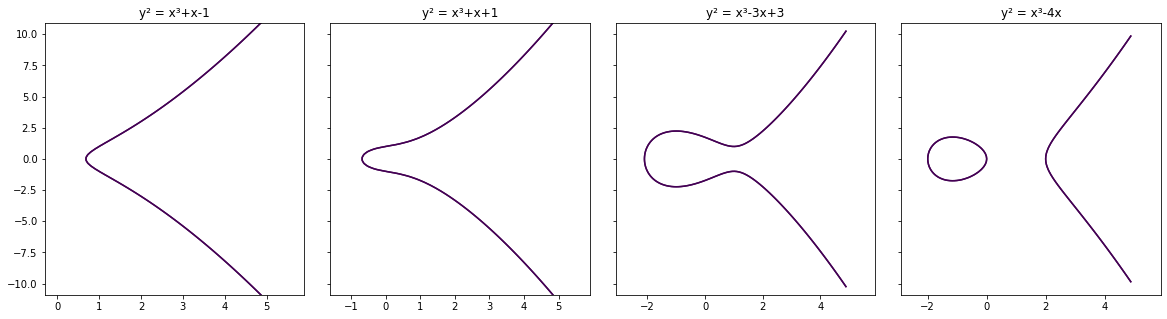

In [157]:
# calc_point_on_ec = ecurve(dom, secp256k1_pow2) #  EllipticCurve function sqrrt(y^2)
fig_example, (ax1_example, ax2_example, ax3_example, ax4_example) = plt.subplots(1,4, sharex='col', sharey='row', gridspec_kw={'hspace': 0.2, 'wspace': 0.1},figsize=(20,5))
plot_elliptic_curve(ax1_example, dom, lambda x: ecurve_power2(1, -1, x), 'y² = x³+x-1')
plot_elliptic_curve(ax2_example, dom, lambda x: ecurve_power2(1, 1, x), 'y² = x³+x+1')
plot_elliptic_curve(ax3_example, dom, lambda x: ecurve_power2(-3, 3, x), 'y² = x³-3x+3')
plot_elliptic_curve(ax4_example, dom, lambda x: ecurve_power2(-4, 0, x), 'y² = x³-4x')

The elliptic curve used by most cryptocurrencies is called the secp256k1 and takes the form
\begin{equation}
y^2 = x^3+x+7
\label{eq:secp256k1}
\tag{2}
\end{equation}

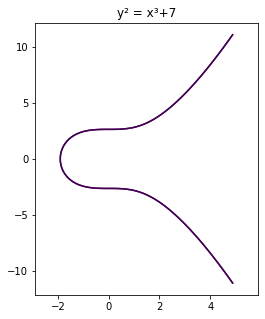

In [158]:
fig_secp256k1, (ax_secp256k1) = plt.subplots(1,1, sharex='col', sharey='row', gridspec_kw={'hspace': 0.2, 'wspace': 0.1},figsize=(4,5))
plot_elliptic_curve(ax_secp256k1, dom, secp256k1_pow2, 'y² = x³+7')

## Finite field
The elliptic curve operation for point addition are different than normal addition. With normal addition you would expect that point1 (x1, y1) + point2 (x2, y2) would equal (x1+1x2, y1+y2). This is not so with elliptic curve where the add operation is defined differently: When you add two points on a elliptic curve together, you get a third point on the curve.

The process is can described as when you have 2 points on a elliptic curve, you draw a line bewteen the points, determine where it intersects the curve. This intersection point is then reflected across the x-axis (i.e multiply the y-coordinate by -1 (x, y*-1)).

A example of addition would be:

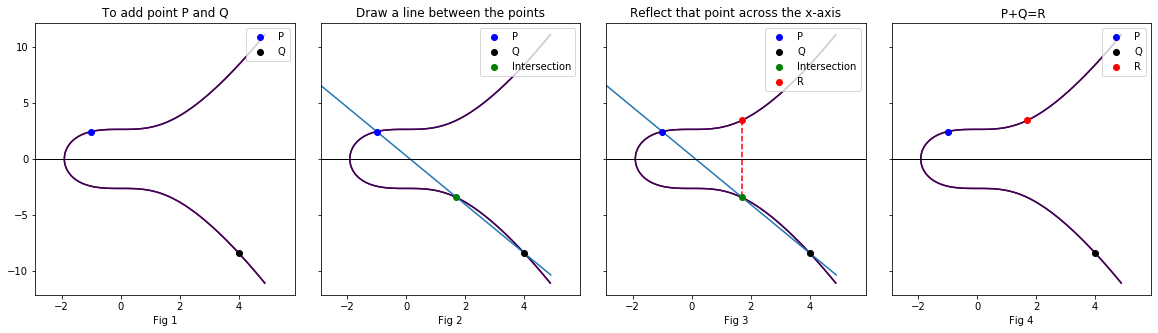

In [159]:
fig_intersec, (ax1_intersec, ax2_intersec, ax3_intersec, ax4_intersec) = plt.subplots(1,4, sharex='col', sharey='row', gridspec_kw={'hspace': 0.2, 'wspace': 0.1},figsize=(20,5))
plot_elliptic_curve(ax1_intersec, dom, secp256k1_pow2, 'To add point P and Q')
plot_elliptic_curve(ax2_intersec, dom, secp256k1_pow2, 'Draw a line between the points')
plot_elliptic_curve(ax3_intersec, dom, secp256k1_pow2, 'Reflect that point across the x-axis')
plot_elliptic_curve(ax4_intersec, dom, secp256k1_pow2, ' P+Q=R')

# Arbitrary points on elliptic curve
points = ecurve(pd.array([-1, 4]), secp256k1_pow2)
point1 = (points.x[0], points.y[0])
point2 = (points.x[1], points.y_neg[1])

m, c = calc_straight_line_params(point1=point1, point2=point2) # Calculate straight line paramaters giving the points

straight_line_partial = lambda x: straight_line(m, c, x) # Straight line function with paramaters

# Calculate intersections between the Straight line function and the EllipticCurve function
intersections = calc_intersection(domain=dom, ecurve_power2_partial_func=secp256k1_pow2, straight_line_partial_func=straight_line_partial)

# First plot
ax1_intersec.plot(intersections.x[0], intersections.y[0], "o", label="P", c='b')
ax1_intersec.plot(intersections.x[2], intersections.y[2], "o", label="Q", c='k')
ax1_intersec.legend()
ax1_intersec.set_xlabel("Fig 1")
ax1_intersec.axhline(linewidth=1, color='k')

# Second plot
plot_straight_line(axs=ax2_intersec, domain=dom, straight_line_partial_func=straight_line_partial, title="")
ax2_intersec.plot(intersections.x[0], intersections.y[0], "o", label="P", c='b')
ax2_intersec.plot(intersections.x[2], intersections.y[2], "o", label="Q", c='k')
ax2_intersec.plot(intersections.x[1], intersections.y[1], "o", label="Intersection", c='g')
ax2_intersec.legend()
ax2_intersec.set_xlabel("Fig 2")
ax2_intersec.axhline(linewidth=1, color='k')

# Third plot
plot_straight_line(axs=ax3_intersec, domain=dom, straight_line_partial_func=straight_line_partial, title="")
ax3_intersec.plot(intersections.x[0], intersections.y[0], "o", label="P", c='b')
ax3_intersec.plot(intersections.x[2], intersections.y[2], "o", label="Q", c='k')
ax3_intersec.plot(intersections.x[1], intersections.y[1], "o", label="Intersection", c='g')
ax3_intersec.plot(intersections.x[1], intersections.y[1]*-1, "o", label="R", c='r')
ax3_intersec.legend()
ax3_intersec.set_xlabel("Fig 3")
ax3_intersec.axhline(linewidth=1, color='k')

ax3_intersec.vlines(intersections.x[1], ymin=intersections.y[1], ymax=intersections.y[1]*-1, colors='r', linestyles='dashed')

# Fourth plot
ax4_intersec.plot(intersections.x[0], intersections.y[0], "o", label="P", c='b')
ax4_intersec.plot(intersections.x[2], intersections.y[2], "o", label="Q", c='k')
ax4_intersec.plot(intersections.x[1], intersections.y[1]*-1, "o", label="R", c='r')
ax4_intersec.legend()
ax4_intersec.set_xlabel("Fig 4")
ax4_intersec.axhline(linewidth=1, color='k')

print("")

Steps to find $P+Q$
- Fig1: If you have point $P$ (-1, 2.5) and $Q$ (4.0, -8.4) on the elliptic curve
- Fig2: Draw a line between the points, find the intersect point at (1.7, -3.5)
- Fig3: Reflect the intersect point across the x-axis to found the new point, $R$ (1.7, 3.5)
- Fig4: $P+Q=R$

With elliptic curve cryptography, you do not just add two arbitrary points together, but rather you start with a base point on the curve and add that point to it self. If we start with a base point $P$ than we have to find a line that goes through $P$ and $P$. Unfortunately there are infinite such lines. With elliptic curve cryptography the tangent line is used in this special case. The same process is followed now to calculate $P+P=2P$:

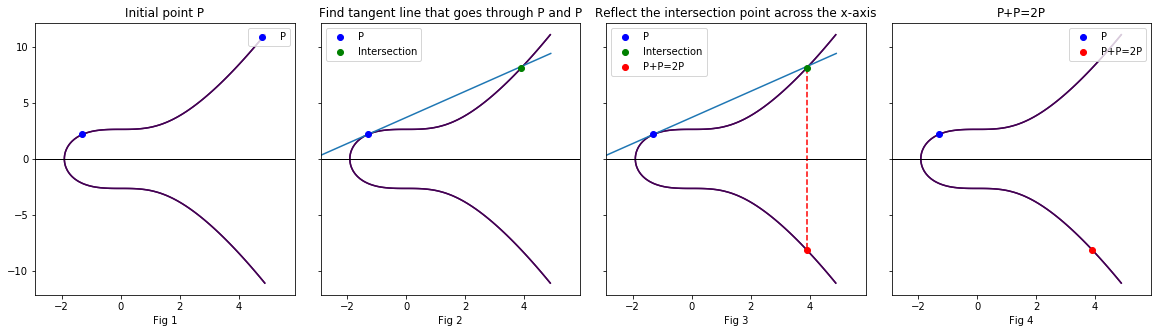

In [160]:
fig_ecurve, (ax1_ecurve, ax2_ecurve, ax3_ecurve, ax4_ecurve) = plt.subplots(1,4, sharex='col', sharey='row', gridspec_kw={'hspace': 0.2, 'wspace': 0.1},figsize=(20,5))
plot_elliptic_curve(ax1_ecurve, dom, secp256k1_pow2, 'Initial point P')
plot_elliptic_curve(ax2_ecurve, dom, secp256k1_pow2, 'Find tangent line that goes through P and P')
plot_elliptic_curve(ax3_ecurve, dom, secp256k1_pow2, 'Reflect the intersection point across the x-axis')
plot_elliptic_curve(ax4_ecurve, dom, secp256k1_pow2, 'P+P=2P')

# Choose a arbitrary point P on the elliptic curve
p_points = ecurve(pd.array([-1.3, -1.31]), secp256k1_pow2)
p_point1 = (p_points.x[0], p_points.y[0])
p_point2 = (p_points.x[1], p_points.y[1])

m, c = calc_straight_line_params(point1=p_point1, point2=p_point2) # Calculate straight line paramaters giving the points

straight_line_partial = lambda x: straight_line(m, c, x) # Straight line function with paramaters

# Calculate intersections between the Straight line function and the EllipticCurve function
intersections_ecurve = calc_intersection(domain=dom, ecurve_power2_partial_func=secp256k1_pow2, straight_line_partial_func=straight_line_partial)

# First plot
ax1_ecurve.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
ax1_ecurve.legend()
ax1_ecurve.set_xlabel("Fig 1")
ax1_ecurve.axhline(linewidth=1, color='k')

# Second plot
plot_straight_line(axs=ax2_ecurve, domain=dom, straight_line_partial_func=straight_line_partial, title="")
ax2_ecurve.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
ax2_ecurve.plot(intersections_ecurve.x[0], intersections_ecurve.y[0], "o", label="Intersection", c='g')
ax2_ecurve.legend()
ax2_ecurve.set_xlabel("Fig 2")
ax2_ecurve.axhline(linewidth=1, color='k')

# Third plot
plot_straight_line(axs=ax3_ecurve, domain=dom, straight_line_partial_func=straight_line_partial, title="")
# ax3_ecurve.plot(intersections_ecurve.x[0], intersections_ecurve.y[0], "o", label="P", c='b')
ax3_ecurve.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
ax3_ecurve.plot(intersections_ecurve.x[0], intersections_ecurve.y[0], "o", label="Intersection", c='g')
ax3_ecurve.plot(intersections_ecurve.x[0], intersections_ecurve.y[0]*-1, "o", label="P+P=2P", c='r')
ax3_ecurve.legend()
ax3_ecurve.set_xlabel("Fig 3")
ax3_ecurve.axhline(linewidth=1, color='k')

ax3_ecurve.vlines(intersections_ecurve.x[0], ymin=intersections_ecurve.y[0], ymax=intersections_ecurve.y[0]*-1, colors='r', linestyles='dashed')

# Fourth plot
ax4_ecurve.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
# ax4_ecurve.plot(intersections_ecurve.x[0], intersections_ecurve.y[0], "o", label="P", c='b')
ax4_ecurve.plot(intersections_ecurve.x[0], intersections_ecurve.y[0]*-1, "o", label="P+P=2P", c='r')

ax4_ecurve.legend()
ax4_ecurve.set_xlabel("Fig 4")
ax4_ecurve.axhline(linewidth=1, color='k')

print("")

Now that we have $2P$, we can add $P$ again to get $3P$, see the example below which follows the same process as before. Draw a line between $P$ and $2P$, find the intersect and reflect this intersect value across the x-axis to find $3P$.

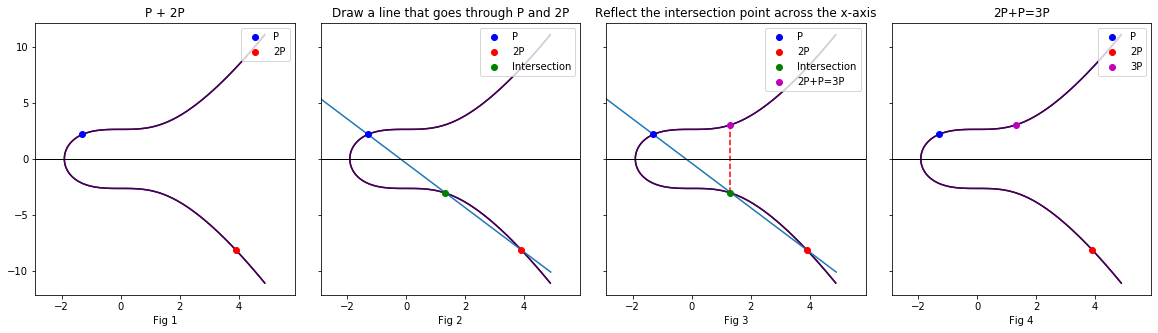

In [161]:
fig_ecurve3P, (ax1_ecurve3P, ax2_ecurve3P, ax3_ecurve3P, ax4_ecurve3P) = plt.subplots(1,4, sharex='col', sharey='row', gridspec_kw={'hspace': 0.2, 'wspace': 0.1},figsize=(20,5))
plot_elliptic_curve(ax1_ecurve3P, dom, secp256k1_pow2, 'P + 2P')
plot_elliptic_curve(ax2_ecurve3P, dom, secp256k1_pow2, 'Draw a line that goes through P and 2P')
plot_elliptic_curve(ax3_ecurve3P, dom, secp256k1_pow2, 'Reflect the intersection point across the x-axis')
plot_elliptic_curve(ax4_ecurve3P, dom, secp256k1_pow2, '2P+P=3P')

# Use P and 2P from previous run
p_point1 = (p_points.x[0], p_points.y[0])
p_point2 = (intersections_ecurve.x[0], intersections_ecurve.y[0]*-1)

m, c = calc_straight_line_params(point1=p_point1, point2=p_point2) # Calculate straight line paramaters giving the points

straight_line_partial = lambda x: straight_line(m, c, x) # Straight line function with paramaters

# Calculate intersections between the Straight line function and the EllipticCurve function
intersections = calc_intersection(domain=dom, ecurve_power2_partial_func=secp256k1_pow2, straight_line_partial_func=straight_line_partial)

# First plot
ax1_ecurve3P.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
ax1_ecurve3P.plot(intersections_ecurve.x[0], intersections_ecurve.y[0]*-1, "o", label="2P", c='r')
ax1_ecurve3P.legend()
ax1_ecurve3P.set_xlabel("Fig 1")
ax1_ecurve3P.axhline(linewidth=1, color='k')

# Second plot
plot_straight_line(axs=ax2_ecurve3P, domain=dom, straight_line_partial_func=straight_line_partial, title="")
ax2_ecurve3P.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
ax2_ecurve3P.plot(intersections_ecurve.x[0], intersections_ecurve.y[0]*-1, "o", label="2P", c='r')
ax2_ecurve3P.plot(intersections.x[1], intersections.y[1], "o", label="Intersection", c='g')

ax2_ecurve3P.legend()
ax2_ecurve3P.set_xlabel("Fig 2")
ax2_ecurve3P.axhline(linewidth=1, color='k')

# Third plot
plot_straight_line(axs=ax3_ecurve3P, domain=dom, straight_line_partial_func=straight_line_partial, title="")
ax3_ecurve3P.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
ax3_ecurve3P.plot(intersections_ecurve.x[0], intersections_ecurve.y[0]*-1, "o", label="2P", c='r')
ax3_ecurve3P.plot(intersections.x[1], intersections.y[1], "o", label="Intersection", c='g')
ax3_ecurve3P.plot(intersections.x[1], intersections.y[1]*-1, "o", label="2P+P=3P", c='m')
ax3_ecurve3P.legend()
ax3_ecurve3P.set_xlabel("Fig 3")
ax3_ecurve3P.axhline(linewidth=1, color='k')

ax3_ecurve3P.vlines(intersections.x[1], ymin=intersections.y[1], ymax=intersections.y[1]*-1, colors='r', linestyles='dashed')

# Fourth plot
ax4_ecurve3P.plot(p_points.x[0], p_points.y[0], "o", label="P", c='b')
ax4_ecurve3P.plot(intersections_ecurve.x[0], intersections_ecurve.y[0]*-1, "o", label="2P", c='r')
ax4_ecurve3P.plot(intersections.x[1], intersections.y[1]*-1, "o", label="3P", c='m')
ax4_ecurve3P.legend()
ax4_ecurve3P.set_xlabel("Fig 4")
ax4_ecurve3P.axhline(linewidth=1, color='k')

print("")

The same process now can be used to calculate $4P, 5P ... nP$.

The base point used in secp256k1 curve has the following ($x, y$) coordinates:<br>
$x:$ 55066263022277343669578718895168534326250603453777594175500187360389116729240<br>
$y:$ 32670510020758816978083085130507043184471273380659243275938904335757337482424

In the examples above a base point was choosen to view all the calculated points in small graph.

## Addition properties

In this finite field, addition also has the property of 

\begin{equation}
nP+rP = (n+r)P
\label{eq:addition}
\tag{3}
\end{equation}

A example are $4P+6P = (4+6)P = 10P$. The easiest method to calculate for example $10P$ would require 4 calculations:<br>

$$
\begin{align}
P+P &= 2P \\
2P+2P &= 4P \\
4P+4P &= 8P \\
8P+2P &= 10P \\
\end{align}
$$

## Diffie–Hellman key exchange

In this section we will exploring the Diffie–Hellman key exchange (DH). This will serve as a basis to understand Elliptic curve cryptography. DH is one of the earliest practical examples of public key exchange implemented within the field of cryptography. 

Encryption is the process of converting information or data into a code to allow only the intended precipitant to decode and read the message. Often times this encryption/decryption is done with a shared secret key. In the following example we will show how two parties can get a shared key (in the past, they physically shared the key on a piece of paper). 

Let's start with the example of Nick and Connie, they want to sent messages to each other without being eavesdropped on. They will share a arbitary number: $g$, this is sent over the internet and could have intercepted, but that does not matter. Nick and Connie also create their own secret key (a big number) and do not share it with anybody:
$$
\begin{align}
Nick&: n  \\
Connie&: c
\end{align}
$$

Then they will raise the arbitary number $g$ to the power of there secret key:

$$
\begin{align}
Nick: g^n &= H_n \\
Connie: g^c &= H_c
\tag{4}
\end{align}
$$

Onces they have the $H$ term, they exchange that to each other. $g, H_n, H_c$ are publicly sent and anybody can view these values. Once they have that $H$ term, they raise it to their secret key.

$$
\begin{align}
Nick: H_c^n &= S \\
Connie: H_n^c &= S
\tag{5}
\end{align}
$$

By doing this, they end up with the same number: $S$, this is the shared key, neither of them had to send it to each other explicitly. Now, for example to encrypt a message using a Caesar cipher (a simple cipher) you can shift all the letters in your message by $S$ number of letters, and shift it back by $S$ number of letters to decrypt (decipher) it. You now have method to encrypt your communication with each other.



To prove equation 5, you can subsitute equation 4 into 5:

$$
Nick: H_c^n = (g^c)^n = g^{cn} = S
$$

$$
Connie: H_n^c = (g^n)^c = g^{nc} = S
$$

Unfortunately we are not done yet, remeber that publicly sent values are $g, H_n, H_c$ are publicly sent. To calculate for example Nick's private $n$ will be trivial since the equation is

$$
Nick: g^n = H_n
$$

Calculating $n$ is as easy as solving this log problem $2^n=16$

What about this discrete log problem: $2^n mod 17 = 16$. This becomes difficult because of the [modulus](https://en.wikipedia.org/wiki/Modular_arithmetic), you do not know how many times over 17 we have gone. Another example of modulus is a clock. If I told you that the start time is 12 o'clock and the end time is 1 o'clock and I ask you how many hours has passed you would not know because you do not know how many times the clock went round. It could be 1 hour, 13 hours or 25 hours and so on. It is because of this fact that you have to start guessing, the discrete log problem is the basis for the DH key exchange. The calculations to create the shared key is simple, but it very difficult to solve for the private key.

Now you can just use the modulus operator in equations 4 and 5

$$
\begin{align}
Nick: g^n \, mod(p) &= H_n \\
Connie: g^c \, mod(p) &= H_c
\tag{6}
\end{align}
$$

You will end up with a shared key again, but this time is very difficult, almost impossible to figure out what the private keys are if the private keys are very big.

$$
\begin{align}
Nick: H_c^n \, mod(p) &= S \\
Connie: H_n^c \, mod(p) &= S
\tag{7}
\end{align}
$$

A more practical example: Nick and Connie both decide publicly on a generator, $G=3$, and a prime modulus, $P=17$. Then Connie decides on a random private key, $c=15$ and Nick does the same $n=13$.

$$
\begin{align}
Nick: G^n \, mod(p) &= H_n \\
3^{13} mod 17 &= 12\\
Connie: G^c \, mod(p) &= H_c \\
3^{15} mod 17 &= 6
\tag{6}
\end{align}
$$

Nick send $H_n=12$ publicly to Connie, and Connie sends $H_c=6$ to Nick publicly. Now the heart of the trick, Nick takes Connies publicly sent value and raises it to the power of his private number, and vice versa to obtain the same shared secret of 10.

$$
\begin{align}
Nick: H_c^n \, mod(p) &= S \\
 6^{13} mod 17 &= 10 \\
Connie: H_n^c \, mod(p) &= S \\
12^{15}mod 17 &= 10
\tag{7}
\end{align}
$$

For the DH, the reason that we choose a prime number for the modulus, is that this guarantees the group is cyclic. It also has a other property, because it is a modulus of a prime ($p$), a generator exists ($g$). A generator is smaller than the prime ($<p$), it will produce all the numbers from $1$ to $p-1$ exactly once with $p^x mod \, g$ where $x = 1, 2 ... p-1$. A example with a prime of 7, then the generator is 5:
$$
\begin{align}
5^1 mod \, 7 &= 5 \\
5^2 mod \, 7 &= 4 \\
5^3 mod \, 7 &= 6 \\
5^4 mod \, 7 &= 2 \\
5^5 mod \, 7 &= 3 \\
5^6 mod \, 7 &= 1 \\
\end{align}
$$

## Elliptic curve discrete log problem

If you look back now at Elliptic curve's addition rule in equation 3, where $nP$ are represented by $nP=P+P+P+...$<br>
We can use the same form of equation 4 in the DH and apply it to EC:

$$
\begin{align}
nG &= H_n
\tag{8}
\end{align}
$$

where $G$ is the starting point and $H_n$ is the end point. $n$ is amount of times that $g$ is added to each self. Even if you know what $G$ and $H_n$ is, it very difficult to figure out what $n$ is. 

Knwowing this, we can just use the DH procedure with these elliptic curve equations and it end's up working the same.

$$
\begin{align}
Nick: nG &= H_n \\
Connie: cG &= H_c
\tag{9}
\end{align}
$$

where $G, H_n, H_c$ are publicly sent. The shared public key can also be calculated in the same way as DH:

$$
\begin{align}
Nick: nH_c &= S \\
Connie: cH_n &= S
\tag{10}
\end{align}
$$

With the DF, the modulus allows to take the possible answers to the exponent problem and reduce the possible set of numbers. Using this $2^n mod 17 = 16$ example again, because of the mod 17, you limit the possible answers to 16. Now in EC, you also can take the modulus of the curve from being a function with infinite values to a finite set of values.

\begin{align}
y^2 &= x^3+ax+b\\ 
y^2 mod p &= (x^3+ax+b)\, mod p
\label{eq:ecurve}
\tag{11}
\end{align}

where $p$ is a prime number, it is a prime number to ensure that addition and multiplication operations can always be undone.<br>
In secp256k1, $p$ is the largest prime that is smaller than $2^{256}$, this would be $2^{256}–2^{32}–977 = $

In [44]:
p = 2**256 - 2**32 - 977
p

115792089237316195423570985008687907853269984665640564039457584007908834671663

This means that x and y coordinates of the elliptic curve can be any number up to this prime.

In [63]:
# http://en.wikibooks.org/wiki/Algorithm_Implementation/Mathematics/Extended_Euclidean_algorithm
def egcd(a, b):
    x,y, u,v = 0,1, 1,0
    while a != 0:
        q, r = b//a, b%a
        m, n = x-u*q, y-v*q
        b,a, x,y, u,v = a,r, u,v, m,n
    return b, x, y

# calculate modular inverse
def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        return None  # modular inverse does not exist
    else:
        return x % m

# ecurve(dom, secp256k1_pow2).y % 7777
# secp256k1_pow2(dom) % 5


In [204]:
# https://andrea.corbellini.name/2015/05/23/elliptic-curve-cryptography-finite-fields-and-discrete-logarithms/
def extended_euclidean_algorithm(a, b):
    """
    Returns a three-tuple (gcd, x, y) such that
    a * x + b * y == gcd, where gcd is the greatest
    common divisor of a and b.

    This function implements the extended Euclidean
    algorithm and runs in O(log b) in the worst case.
    """
    s, old_s = 0, 1
    t, old_t = 1, 0
    r, old_r = b, a

    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t

    return old_r, old_s, old_t


def inverse_of(n, p):
    """
    Returns the multiplicative inverse of
    n modulo p.

    This function returns an integer m such that
    (n * m) % p == 1.
    """
    gcd, x, y = extended_euclidean_algorithm(n, p)
    assert (n * x + p * y) % p == gcd

    if gcd != 1:
        # Either n is 0, or p is not a prime number.
        raise ValueError(
            '{} has no multiplicative inverse '
            'modulo {}'.format(n, p))
    else:
        return x % p

In [342]:
# https://andrea.corbellini.name/2015/05/23/elliptic-curve-cryptography-finite-fields-and-discrete-logarithms/
# https://www.youtube.com/watch?v=NnyZZw8d1wI
p = 19
ecurve_pow2_mod = lambda x: ecurve_power2(-7, 10, x) % p

dom = domain(0,p, 1) # Domain
dom = pd.array(dom)
dom = dom[dom>0]

y2_mod = pd.DataFrame({'x': dom, 'y_1': ecurve_pow2_mod(dom), 'y_2': ecurve_pow2_mod(dom)})

# plt.plot(y2_mod.x, y, 'ro')
# plt.show()
y2_mod

,x,y_1,y_2
0,1.0,4.0,4.0
1,2.0,4.0,4.0
2,3.0,16.0,16.0
3,4.0,8.0,8.0
4,5.0,5.0,5.0
5,6.0,13.0,13.0
6,7.0,0.0,0.0
7,8.0,10.0,10.0
8,9.0,11.0,11.0
9,10.0,9.0,9.0


In [341]:
ecurve_pow2_mod(5)

5

In [282]:
inverse_of(16, 19)

6

In [217]:
inverse_of(5, 19)

4

In [250]:
x = 6
g = [5,2,3]
gp = pd.array(g)
df = pd.DataFrame({'x': gp, 'diff': gp-4})
df = df.sort_values(by ='diff' )
f = lambda x: x + 1
f(a for a in df.x)

TypeError: unsupported operand type(s) for +: 'generator' and 'int'

In [323]:
# https://medium.com/asecuritysite-when-bob-met-alice/nothing-up-my-sleeve-creating-a-more-trust-world-with-the-elliptic-curve-pedersen-commitment-7b363d136579
2 ^= 1

SyntaxError: can't assign to literal (<ipython-input-323-7ae6a2adc2c7>, line 2)

In [333]:
a = 1
b = 2
a ^= b
a

3

In [329]:
b

2